Mount Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [22]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import re

Remove numeric and empty texts

In [23]:
TRAINING_DATA_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/training.1600000.processed.noemoticon.csv'

df = pd.read_csv(TRAINING_DATA_DIR, encoding ='ISO-8859-1', usecols = ['target', 'text'], error_bad_lines=False)
df['target'] = df['target'].map(lambda x : 1 if int(x) == 4 else 0)
df.sample(6)

,target,text
68285,0,My B Bear is not himself. Nothing so sad as a...
722015,0,I absolutely hate working lately
994271,1,@rainwriterjones Receiving you loud and clear ...
595149,0,Back from my first ride on my new bike. Bike ...
400706,0,I need to start something new!! I came to the ...
948670,1,@JetGirlArt order your SiP Omnibus yet?


Balance and shuffle training data

In [24]:
df['target'].value_counts()

0    799999
1    248576
Name: target, dtype: int64

In [0]:
pos_df = df.loc[df['target'] == 1]
neg_df = df.loc[df['target'] == 0].sample(248576)
normalized_df = pd.concat([neg_df, pos_df])
normalized_df_shuffled = normalized_df.sample(frac=1)

In [26]:
normalized_df_shuffled['target'].value_counts()

1    248576
0    248576
Name: target, dtype: int64

Clean and stem training data

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.stem.snowball import SnowballStemmer
def clean_text(text):

  ## Remove URLs
  text = re.sub(r" http.* \/", "", text)
  text = re.sub(r" .*\.com", "", text)

  ## Remove puncuation
  text = text.translate(string.punctuation)

  ## Convert words to lower case and split them
  text = text.lower().split()

  ## Remove stop words and words beginning with '@'
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops and w[0] != '@' and len(w) >= 3]
  text = " ".join(text)

  ## Clean the text
  removelist = '!?'
  text = re.sub(r'[^\w'+removelist+']', ' ',text)
  text = re.sub(r"!", " ! ", text)
 
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
    
  ## Stemming
  text = text.split()
  stemmer = SnowballStemmer('english')
  stemmed_words = [stemmer.stem(word) for word in text]
  text = " ".join(stemmed_words)
 
  return text

In [29]:
# apply the above function to normalized_df_shuffled['text']
normalized_df_shuffled['text'] = normalized_df_shuffled['text'].map(lambda x: clean_text(x))
normalized_df_shuffled.sample(6)

,target,text
1041730,1,laugh at quot you know happen quot http tr im ...
3761,0,glue come off sooo irrit
506674,0,cri
986080,1,teacher forgot bring tests?? lucki
339682,0,eh btw tokyoflash die me light didnt drop anyth
719756,0,start go sale friday ! ! ! piss mom bitch say ...


Tokenize training data

In [0]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(normalized_df_shuffled['text'])

input_length = 25
sequences = tokenizer.texts_to_sequences(normalized_df_shuffled['text'])
data = pad_sequences(sequences, maxlen=input_length)

Get Glove embeddings

In [31]:
glove_dims = 100
GLOVE_100D_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/glove.twitter.27B/glove.twitter.27B.100d.txt'
GLOVE_25D_DIR = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/glove.twitter.27B/glove.twitter.27B.25d.txt'

embeddings_index = dict()
f = open(GLOVE_100D_DIR)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, glove_dims))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Develop model

In [0]:
# uses tanh activation for last layer
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, glove_dims, input_length=input_length, weights=[embedding_matrix]))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(input_length))
model_glove.add(Dense(1, activation='tanh'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
labels = normalized_df_shuffled['target']
model_glove.fit(data, np.array(labels), validation_split=0.2, epochs = 5)

Train on 397721 samples, validate on 99431 samples
Epoch 1/5
397721/397721 [==============================] - 338s 849us/step - loss: 0.5356 - acc: 0.7259 - val_loss: 0.5080 - val_acc: 0.7470
Epoch 2/5
397721/397721 [==============================] - 339s 852us/step - loss: 0.4998 - acc: 0.7519 - val_loss: 0.5049 - val_acc: 0.7484
Epoch 3/5
397721/397721 [==============================] - 337s 848us/step - loss: 0.4806 - acc: 0.7646 - val_loss: 0.5197 - val_acc: 0.7482
Epoch 4/5
397721/397721 [==============================] - 338s 850us/step - loss: 0.4627 - acc: 0.7758 - val_loss: 0.5160 - val_acc: 0.7478
Epoch 5/5
397721/397721 [==============================] - 338s 849us/step - loss: 0.4454 - acc: 0.7862 - val_loss: 0.5202 - val_acc: 0.7440


LDA Helpers

In [0]:
MODEL_TYPE = 'lstm'
SANDY_HOOK = 'sandyhook'
VEGAS = 'vegas'
BERNARDINO = 'bernardino'
ORLANDO = 'orlando'
PARKLAND = 'parkland'
SHOOTINGS = [SANDY_HOOK, BERNARDINO, ORLANDO, VEGAS, PARKLAND]
SHOOTINGS_TEST_DIR_PREFIX = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/TestData'
SHOOTINGS_TEST_DIR_SUFFIXES = {SANDY_HOOK:'/Sandy Hook 2012', BERNARDINO:'/Bernardino 2015', ORLANDO:'/Orlando 2016', VEGAS:'/Vegas 2017', PARKLAND:'/Parkland 2018'}
SHOOTINGS_PRED_DIR_PREFIX = '/content/drive/My Drive/2019-2020/CS 221/CS 221 Final Project/Final Project Files/TestPredictions'
SHOOTINGS_PRED_DIR_SUFFIXES = {SANDY_HOOK:'/Sandy Hook 2012 Predictions', BERNARDINO:'/Bernardino 2015 Predictions', ORLANDO:'/Orlando 2016 Predictions', VEGAS:'/Vegas 2017 Predictions', PARKLAND:'/Parkland 2018 Predictions'}
NUM_SAMPLED = 300
FIRST_DAY = -4
LAST_DAY = 55
THRESHOLD = 0.3

def get_dirs(shooting, day):
  test_dir = '{}{}'.format(SHOOTINGS_TEST_DIR_PREFIX, SHOOTINGS_TEST_DIR_SUFFIXES[shooting])
  pred_dir = '{}{}'.format(SHOOTINGS_PRED_DIR_PREFIX, SHOOTINGS_PRED_DIR_SUFFIXES[shooting])
  test_day_file_name = '{}_{}_{}.csv'.format(shooting, day, NUM_SAMPLED)
  test_day_dir = '{}/{}'.format(test_dir, test_day_file_name)
  pred_day_file_name = '{}_{}_{}_{}_preds.csv'.format(shooting, day, NUM_SAMPLED, MODEL_TYPE)
  pred_day_dir = '{}/{}'.format(pred_dir, pred_day_file_name)
  return test_day_dir, pred_day_dir

def tokenize_test_data(cleaned_test_df):
  tokenizer = Tokenizer(num_words=vocabulary_size)
  tokenizer.fit_on_texts(cleaned_test_df['text'])

  sequences = tokenizer.texts_to_sequences(cleaned_test_df['text'])
  test_data = pad_sequences(sequences, maxlen=input_length)
  return test_data

def get_label(pred_y):
  if pred_y <= THRESHOLD:
    return 0
  else:
    return 1

import csv
from gensim import corpora, models
def predict_file(test_file_dir, test_pred_file_dir, shooting_offtopic_idx, lda_map_dict):
  test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
  cleaned_test_df = test_df
  cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
  test_data = tokenize_test_data(cleaned_test_df)

  f = open(test_pred_file_dir, 'w')
  with f:
    writer = csv.writer(f)
    writer.writerow(['score', 'label'])
    for i, example in enumerate(test_data):
      example_text = cleaned_test_df['text'][i]
      if lda_map_dict[example_text] and lda_map_dict[example_text] not in shooting_offtopic_idx:
        pred_y = model_glove.predict(np.expand_dims(example, axis=0))[0][0]
        label = get_label(pred_y)
        writer.writerow([example_text, str(pred_y), str(label)])
  f.close()

Build LDA Model

In [42]:
import csv
from gensim import corpora, models
import nltk
nltk.download('stopwords')

lda_map_dict = dict()
def getAllTweetWordLists(list_of_list_of_tokens,test_file_dir, test_pred_file_dir, curr_tweet_id):
  test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
  clean_test_df = test_df
  cleaned_test_df = test_df
  cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
  test_data = tokenize_test_data(cleaned_test_df)

  # LDA make model
  for tweet in cleaned_test_df['text']:
    lda_map_dict[tweet] = curr_tweet_id
    curr_tweet_id += 1
    list_of_list_of_tokens.append(tweet.split(' '))
  return list_of_list_of_tokens, curr_tweet_id

def getLDAModel(shootingName, numTopics, numWords):
  vocabulary_size = 20000
  list_of_list_of_tokens = []
  num_topics = numTopics
  num_words = numWords
  curr_tweet_id = 0
  for day in range(FIRST_DAY, LAST_DAY + 1):
    test_day_dir, pred_day_dir = get_dirs(shootingName, day)
    #test_day_dir = '/content/drive/My Drive/CS 221 Final Project/Final Project Files/TestData/Sandy Hook 2012/sandyhook_1_300.csv'
    #pred_day_dir = '/content/drive/My Drive/CS 221 Final Project/Final Project Files/TestPredictions/Sandy Hook 2012 Predictions/sandyhook_1_300_logreg_preds.csv'
    list_of_list_of_tokens, curr_tweet_id = getAllTweetWordLists(list_of_list_of_tokens, test_day_dir, pred_day_dir, curr_tweet_id)
  dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
  dictionary_LDA.filter_extremes(no_below=3)
  corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]
  lda_model = models.LdaModel(corpus, num_topics=numTopics, id2word=dictionary_LDA, passes=4, alpha=[0.01]*numTopics, eta=[0.01]*len(dictionary_LDA.keys()))
  topics = lda_model.show_topics(formatted=True, num_topics=numTopics, num_words=numWords)
  return lda_model, corpus, topics

def printEnumTopics(topics):
  ind = 0
  for i,topic in topics:
    print("topic #" + str(ind)+ "; with ID:" + str(i) + " is " + str(topic))
    ind += 1

def getTopicForTweetInd(model, mycorpus, topics, ind):
  lda_model = model
  corpus = mycorpus
  print("corpus is len" + str(len(corpus)))
  # ind = 2
  # BOW embedding
  #print(corpus[ind])
  #lemmatized/tokenized tweet
  #print(list_of_list_of_tokens[ind])
  # Closest topic see above
  print(list_of_list_of_tokens[ind])
  maxlikelihood = -1
  topicchosen = -1
  print(lda_model[corpus[ind]])
  for a in lda_model[corpus[ind]]:
    if a[1] > maxlikelihood:
      maxlikelihood = a[1]
      topicchosen = a[0]
  print("Most likely topic: " + str(topicchosen) + "\n And the topic is: "+ str(topics[topicchosen]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Testing

In [43]:
sandyhook_lda_model, sandyhook_corpus, sandyhook_topics = getLDAModel(SANDY_HOOK, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [44]:
printEnumTopics(sandyhook_topics)
ind = 4
getTopicForTweetInd(sandyhook_lda_model, sandyhook_corpus, sandyhook_topics, ind)
print()
print(str(lda_map_dict['teacher sandi hook crazi precaut']))

topic #0; with ID:0 is 0.178*"super" + 0.067*"choir" + 0.054*"kill"
topic #1; with ID:1 is 0.081*"obama" + 0.064*"citizen" + 0.061*"youtub"
topic #2; with ID:2 is 0.049*"sandyhook" + 0.039*"break" + 0.037*"good"
topic #3; with ID:3 is 0.049*"sandyhook" + 0.046*"elementari" + 0.046*"famili"
topic #4; with ID:4 is 0.170*"father" + 0.040*"dead" + 0.034*"victim"
topic #5; with ID:5 is 0.038*"year" + 0.034*"man" + 0.031*"evid"
topic #6; with ID:6 is 0.173*"gun" + 0.051*"control" + 0.038*"law"
topic #7; with ID:7 is 0.067*"think" + 0.055*"peopl" + 0.049*"kid"
topic #8; with ID:8 is 0.067*"i" + 0.053*"take" + 0.048*"m"
topic #9; with ID:9 is 0.437*"!" + 0.081*"own" + 0.043*"shooter"
topic #10; with ID:10 is 0.056*"shoot" + 0.050*"hear" + 0.038*"live"
topic #11; with ID:11 is 0.089*"student" + 0.054*"school" + 0.042*"support"
topic #12; with ID:12 is 0.044*"look" + 0.035*"help" + 0.035*"actor"
topic #13; with ID:13 is 0.079*"teacher" + 0.064*"gun" + 0.060*"slain"
topic #14; with ID:14 is 0.154

In [80]:
sandy_hook_offtopic_idx = {8, 19}
shooting = SANDY_HOOK
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, sandy_hook_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

lstm predictions made for sandyhook


In [46]:
vegas_lda_model, vegas_corpus, vegas_topics = getLDAModel(VEGAS, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [47]:
printEnumTopics(vegas_topics)
ind = 4
getTopicForTweetInd(vegas_lda_model, vegas_corpus, vegas_topics, ind)

topic #0; with ID:0 is 0.042*"week" + 0.036*"t" + 0.031*"happen"
topic #1; with ID:1 is 0.056*"las" + 0.037*"http" + 0.033*"game"
topic #2; with ID:2 is 0.056*"still" + 0.034*"think" + 0.023*"support"
topic #3; with ID:3 is 0.139*"http" + 0.101*"las" + 0.089*"video"
topic #4; with ID:4 is 0.090*"las" + 0.070*"http" + 0.036*"2017"
topic #5; with ID:5 is 0.053*"s" + 0.032*"white" + 0.031*"team"
topic #6; with ID:6 is 0.062*"las" + 0.040*"kill" + 0.039*"hotel"
topic #7; with ID:7 is 0.043*"s" + 0.030*"run" + 0.027*"lol"
topic #8; with ID:8 is 0.126*"las" + 0.113*"https" + 0.084*"via"
topic #9; with ID:9 is 0.145*"i" + 0.100*"m" + 0.038*"las"
topic #10; with ID:10 is 0.101*"las" + 0.062*"http" + 0.057*"shoot"
topic #11; with ID:11 is 0.077*"las" + 0.053*"http" + 0.030*"say"
topic #12; with ID:12 is 0.075*"free" + 0.072*"play" + 0.058*"win"
topic #13; with ID:13 is 0.056*"new" + 0.042*"next" + 0.032*"5"
topic #14; with ID:14 is 0.056*"gun" + 0.034*"las" + 0.031*"talk"
topic #15; with ID:15 

In [81]:
vegas_offtopic_idx = {0, 1, 3, 4, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19}
shooting = VEGAS
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, vegas_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

lstm predictions made for vegas


In [49]:
bernardino_lda_model, bernardino_corpus, bernardino_topics = getLDAModel(BERNARDINO, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [50]:
printEnumTopics(bernardino_topics)
ind = 4
getTopicForTweetInd(bernardino_lda_model, bernardino_corpus, bernardino_topics, ind)

topic #0; with ID:0 is 0.047*"job" + 0.044*"ca" + 0.037*"find"
topic #1; with ID:1 is 0.166*"attack" + 0.087*"terror" + 0.061*"sourc"
topic #2; with ID:2 is 0.050*"fill" + 0.048*"shoot" + 0.041*"news"
topic #3; with ID:3 is 0.117*"shooter" + 0.069*"public" + 0.058*"minut"
topic #4; with ID:4 is 0.070*"claim" + 0.070*"counti" + 0.049*"year"
topic #5; with ID:5 is 0.230*"!" + 0.197*"via" + 0.156*"https"
topic #6; with ID:6 is 0.109*"call" + 0.092*"cordillera" + 0.086*"centenario"
topic #7; with ID:7 is 0.070*"california" + 0.058*"mass" + 0.046*"drive"
topic #8; with ID:8 is 0.072*"woman" + 0.055*"offici" + 0.051*"los"
topic #9; with ID:9 is 0.073*"health" + 0.071*"american" + 0.049*"muslim"
topic #10; with ID:10 is 0.142*"i" + 0.128*"m" + 0.070*"s"
topic #11; with ID:11 is 0.422*"avail" + 0.076*"fbi" + 0.041*"shoot"
topic #12; with ID:12 is 0.097*"gun" + 0.059*"shoot" + 0.053*"flag"
topic #13; with ID:13 is 0.114*"ca" + 0.079*"moder" + 0.077*"yellow"
topic #14; with ID:14 is 0.106*"bomb"

In [82]:
bernardino_offtopic_idx = {4, 5, 6, 10, 13}
shooting = BERNARDINO
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, bernardino_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

lstm predictions made for bernardino


In [52]:
orlando_lda_model, orlando_corpus, orlando_topics = getLDAModel(ORLANDO, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [53]:
printEnumTopics(orlando_topics)
ind = 4
getTopicForTweetInd(orlando_lda_model, orlando_corpus, orlando_topics, ind)

topic #0; with ID:0 is 0.139*"http" + 0.065*"victim" + 0.046*"shoot"
topic #1; with ID:1 is 0.206*"i" + 0.154*"m" + 0.029*"hall"
topic #2; with ID:2 is 0.120*"http" + 0.118*"like" + 0.103*"video"
topic #3; with ID:3 is 0.083*"t" + 0.055*"can" + 0.040*"https"
topic #4; with ID:4 is 0.067*"free" + 0.052*"want" + 0.040*"ride"
topic #5; with ID:5 is 0.070*"http" + 0.051*"s" + 0.038*"pride"
topic #6; with ID:6 is 0.055*"nice" + 0.044*"game" + 0.038*"lol"
topic #7; with ID:7 is 0.071*"good" + 0.061*"magic" + 0.049*"team"
topic #8; with ID:8 is 0.069*"peopl" + 0.059*"san" + 0.045*"one"
topic #9; with ID:9 is 0.063*"see" + 0.042*"citi" + 0.031*"realli"
topic #10; with ID:10 is 0.044*"come" + 0.040*"go" + 0.038*"get"
topic #11; with ID:11 is 0.045*"justin" + 0.036*"s" + 0.034*"pleas"
topic #12; with ID:12 is 0.080*"new" + 0.080*"http" + 0.051*"say"
topic #13; with ID:13 is 0.197*"bloom" + 0.103*"http" + 0.072*"kati"
topic #14; with ID:14 is 0.079*"http" + 0.073*"fl" + 0.065*"mlg"
topic #15; wit

In [83]:
orlando_offtopic_idx = {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18}
shooting = ORLANDO
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, orlando_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

lstm predictions made for orlando


In [56]:
parkland_lda_model, parkland_corpus, parkland_topics = getLDAModel(PARKLAND, 20, 3) # Once we have this model -- do not regenerate! topic ids will be different next time

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



In [57]:
printEnumTopics(parkland_topics)
ind = 4
getTopicForTweetInd(parkland_lda_model, parkland_corpus, parkland_topics, ind)

topic #0; with ID:0 is 0.055*"victim" + 0.044*"shoot" + 0.023*"school"
topic #1; with ID:1 is 0.080*"hogg" + 0.068*"david" + 0.051*"survivor"
topic #2; with ID:2 is 0.103*"school" + 0.078*"shoot" + 0.044*"shooter"
topic #3; with ID:3 is 0.086*"gun" + 0.068*"survivor" + 0.057*"shoot"
topic #4; with ID:4 is 0.063*"i" + 0.043*"m" + 0.029*"student"
topic #5; with ID:5 is 0.025*"time" + 0.025*"children" + 0.021*"hero"
topic #6; with ID:6 is 0.037*"s" + 0.030*"one" + 0.023*"would"
topic #7; with ID:7 is 0.070*"http" + 0.066*"video" + 0.066*"like"
topic #8; with ID:8 is 0.048*"gun" + 0.026*"backpack" + 0.023*"shooter"
topic #9; with ID:9 is 0.041*"teacher" + 0.036*"gun" + 0.036*"conserv"
topic #10; with ID:10 is 0.042*"fire" + 0.029*"justic" + 0.019*"new"
topic #11; with ID:11 is 0.036*"vega" + 0.026*"trump" + 0.023*"sandi"
topic #12; with ID:12 is 0.076*"https" + 0.052*"student" + 0.045*"ingraham"
topic #13; with ID:13 is 0.319*"!" + 0.020*"kid" + 0.019*"great"
topic #14; with ID:14 is 0.065

In [84]:
parkland_offtopic_idx = {6, 7, 17}
shooting = PARKLAND
for day in range(FIRST_DAY, LAST_DAY + 1):
  test_day_dir, pred_day_dir = get_dirs(shooting, day)
  predict_file(test_day_dir, pred_day_dir, parkland_offtopic_idx, lda_map_dict)
print('{} predictions made for {}'.format(MODEL_TYPE, shooting))

lstm predictions made for parkland


Peek at results

In [85]:
import random
sampled_shootings = random.sample(SHOOTINGS, 2)
sampled_days = range(FIRST_DAY, FIRST_DAY + 3)

for shooting in sampled_shootings:
  for day in sampled_days:
    test_file_dir, pred_file_dir = get_dirs(shooting, day)
    test_df = pd.read_csv(test_file_dir, encoding ='ISO-8859-1', usecols=[0], names=['text'], error_bad_lines=False)
    clean_test_df = test_df
    cleaned_test_df = test_df
    cleaned_test_df['text'] = cleaned_test_df['text'].map(lambda x: clean_text(x))
    pred_df = pd.read_csv(pred_file_dir, usecols=['score', 'label'])
    sampled_indices = random.sample(range(len(test_df)), 3)

    #LDA
    list_of_list_of_tokens = []

    for tweet in cleaned_test_df['text']:
      list_of_list_of_tokens.append(tweet.split(' '))
    dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
    dictionary_LDA.filter_extremes(no_below=3)
    corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]
    #ENDLDA

    for i in sampled_indices:
      print(test_df['text'][i])
      print()
      print(cleaned_test_df['text'][i])
      print()
      print('score:', pred_df['score'][i])
      if pred_df['label'][i] == 0:
        label_description = 'negative'
      else:
        label_description = 'positive'
      print('label:', pred_df['label'][i], label_description)
      print()
      print()

wear vega ? ! !

wear vega ? ! !

score: band las vega alway make great music
label: 0.5583905 positive


well those guy vega know they re do

well those guy vega know they re do

score: ad video playlist http las vega hottest nail salon spa !
label: 0.46195352 positive


may thing freeway vega i 15 short interst

may thing freeway vega i 15 short interst

score: ahhhh can t believ i m go vega see lana wrong
label: 0.07910346 positive


las vega polic respond michael bennett s alleg espn https

las vega polic respond michael bennett s alleg espn https

score: las vega polic respond michael bennett s alleg espn https
label: 0.35965988 positive


believ magic?? hope get vega show too we ll see sure ! !

believ magic?? hope get vega show too we ll see sure ! !

score: believ magic?? hope get vega show too we ll see sure ! !
label: 0.5284089 positive


v i p ticket vega tour decemb ! !

v i p ticket vega tour decemb ! !

score: v i p ticket vega tour decemb ! !
label: 0.71115255 positive



KeyError: ignored

Plot % of negative tweets

In [0]:
def get_percent_negative_tweets(shooting, day1, interval_length):
  combined_pd = pd.DataFrame()
  for i in range(interval_length):
    _, pred_dir_day = get_dirs(shooting, day1 + i)
    pred_df_day = pd.read_csv(pred_dir_day, usecols=['label'])
    combined_pd = pd.concat([combined_pd, pred_df_day], ignore_index=True)
  return 1 - (combined_pd['label'].sum() / combined_pd['label'].count())

One day before + three intervals after event occurs

sandyhook
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [19.64285714285714, 16.722408026755854, 25.657894736842103, 26.329787234042556, 29.166666666666664, 24.33333333333333, 27.333333333333332, 26.5]
bernardino
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [22.416812609457093, 25.66666666666667, 21.666666666666668, 26.66666666666667, 26.5, 28.833333333333332, 23.33333333333333, 31.164383561643838]
orlando
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [23.666666666666668, 26.66666666666667, 26.5, 29.500000000000004, 27.16666666666666, 27.333333333333332, 29.500000000000004, 28.16666666666666]
vegas
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [28.308207705192633, 30.666666666666664, 29.666666666666664, 27.833333333333332, 30.05008347245409, 31.71953255425709, 33.333333333333336, 26.4406779661017]
parkland
x: [0, 1, 2, 3, 4, 5, 6, 7]
y: [30.666666666666664, 30.166666666666664, 34.0, 35.16666666666667, 32.833333333333336, 30.500000000000004, 31.499999999999993, 31.999999999999996]


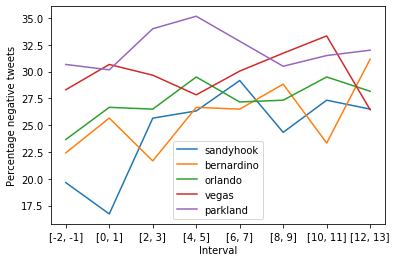

In [87]:
interval_length = 2
for shooting in SHOOTINGS:
  x = []
  y = []
  for i, day in enumerate(range(-2, 14, interval_length)):
    x.append(i)
    y.append(get_percent_negative_tweets(shooting, day, interval_length) * 100)
  print(shooting)
  print('x:', x)
  print('y:', y)
  plt.plot(x, y)
  plt.xlabel('Interval')
  my_xticks = ['[-2, -1]', '[0, 1]', '[2, 3]', '[4, 5]', '[6, 7]', '[8, 9]', '[10, 11]', '[12, 13]']
  plt.xticks(x, my_xticks)
  plt.ylabel('Percentage negative tweets')
  plt.legend(SHOOTINGS)

Tail graphs

sandyhook
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [21.999999999999996, 26.422018348623855, 26.200000000000003, 28.066666666666663, 21.733333333333338, 25.33333333333333, 27.53333333333333, 22.53333333333334, 25.06666666666667, 26.266666666666673, 24.2, 23.4]
bernardino
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [23.22175732217573, 24.6, 27.6, 25.943396226415093, 22.666666666666668, 25.817211474316217, 23.4, 21.962616822429904, 28.47593582887701, 25.86666666666667, 25.0, 21.199999999999996]
orlando
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [25.02113271344041, 27.933333333333334, 26.86666666666667, 30.400000000000006, 26.284189459639762, 27.66666666666666, 27.800000000000004, 29.103214890016915, 26.417611741160773, 28.285523682454972, 28.056112224448892, 27.818545697131427]
vegas
x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y: [27.18035563082134, 29.600000000000005, 30.974632843791728, 28.859060402684566, 28.351206434316357, 26.943699731903482, 27.922511690046758, 28.7055667337357

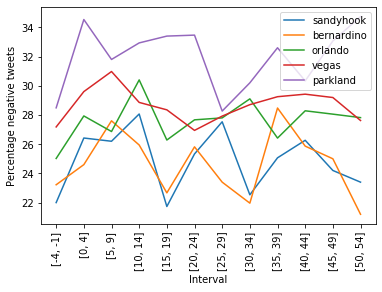

In [88]:
interval_length = 5
for shooting in SHOOTINGS:
  x = []
  y = []
  for i, day in enumerate(range(FIRST_DAY, LAST_DAY, interval_length)):
    x.append(i)
    if day == FIRST_DAY:
      y.append(get_percent_negative_tweets(shooting, day, interval_length - 1) * 100)
    else:
      y.append(get_percent_negative_tweets(shooting, day, interval_length) * 100)
  print(shooting)
  print('x:', x)
  print('y:', y)
  plt.plot(x, y)
  plt.xlabel('Interval')
  my_xticks = ['[-4, -1]', '[0, 4]', '[5, 9]', '[10, 14]', '[15, 19]', '[20, 24]', '[25, 29]', '[30, 34]', '[35, 39]', '[40, 44]', '[45, 49]', '[50, 54]']
  plt.xticks(x, my_xticks)
  plt.ylabel('Percentage negative tweets')
  plt.legend(SHOOTINGS)
  plt.xticks(rotation=90)